In [2]:
%matplotlib inline

In [6]:
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import drizzlepac

import grizli
import grizli.utils
print(grizli.__version__)

1.0.dev1452


### Data and directory structure ###
Download FLT (WFC3/IR) or FLC (ACS WFC or WFC3/UVIS) products.  A typical working directory structure is something like

 * `./RAW/` - Put downloaded files here.  The scripts will make copies of these files and leave these untouched.  Some scripts have default parameters that look for `RAW` (or rather, `../RAW/`) specifically, so just use that unless you plan to change the scripts elsewhere.
 * `./Prep/` - General working directory for processing & analysis.  Can be called anything. 
 * `./Persistence/` - (optional) place to put persistence products downloaded from https://archive.stsci.edu/prepds/persist/search.php

### GOODS-S ERS Demonstration Data ###
The WFC3 ERS program ([GO-11359](http://archive.stsci.edu/proposal_search.php?id=11359&mission=hst&sci_instrume=WFC3)) offers a good demonstration of the Grizli WFC3 processing, with two orbits in each of the two WFC3/IR grisms G102 and G141, within the well-studied GOODS-S/CANDELS/3D-HST survey field.  Download the demonstration data:
```bash
cd [some working directory]
curl -O https://www.stsci.edu/~brammer/Grizli/Files/grizli_ERS_demo.tar.gz
tar xzvf grizli_ERS_demo.tar.gz
```
Unpacking the tarfile produces the directories as above and unpacks the ERS grism (and direct) FLT exposures in the `RAW` directory.  Note that the FLT files have been reprocessed from the original RAW images using [reprocess_wfc3.py](https://github.com/gbrammer/wfc3/blob/master/reprocess_wfc3.py) to account for variable backgrounds during the grism exposures.

In [16]:
# os.chdir([where you downloaded the ERS data])
try:
    os.chdir('//tmp/grizli_wfc3ir_reduction/Prep')
except:
    pass

print(os.getcwd())

/private/tmp/grizli_wfc3ir_reduction/Prep


### File handling ###
The pipeline products are typically put in a `../RAW` directory, though in principle they can be found anywhere.  `Grizli` provides utilities to load lists of FLT exposures and parse their header information to group them into visits / filters.  In the example below, the parse script found four exposures in each of the filters F098M, F140W, G102 and G141.

In [17]:
files = glob.glob('../RAW/*flt.fits')
print(files)
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)

['../RAW/ib6o21qoq_flt.fits', '../RAW/ib6o21r6q_flt.fits', '../RAW/ib6o23rzq_flt.fits', '../RAW/ib6o21qqq_flt.fits', '../RAW/ib6o23rwq_flt.fits', '../RAW/ib6o21raq_flt.fits', '../RAW/ib6o21r7q_flt.fits', '../RAW/ib6o21qnq_flt.fits', '../RAW/ib6o23s0q_flt.fits', '../RAW/ib6o21qmq_flt.fits', '../RAW/ib6o23rsq_flt.fits', '../RAW/ib6o23ruq_flt.fits', '../RAW/ib6o23s2q_flt.fits', '../RAW/ib6o21r8q_flt.fits', '../RAW/ib6o23ryq_flt.fits', '../RAW/ib6o23rtq_flt.fits']
WFC3-ERSII-G01-b6o-21-119.0-F098M 4
WFC3-ERSII-G01-b6o-23-119.0-F140W 4
WFC3-ERSII-G01-b6o-21-119.0-G102 4
WFC3-ERSII-G01-b6o-23-119.0-G141 4


The basic input dictionaries used for the `prep` scripts have two keys: 
* `files` = List of FLT exposures
* `product` = Rootname for output products.

The `visits` list output by the script above contains a list of these dictionaries for all of the groups of exposures.

In [18]:
for i in range(4):
    print(dict(visits[i]))

{'product': 'wfc3-ersii-g01-b6o-21-119.0-f098m', 'files': ['ib6o21qnq_flt.fits', 'ib6o21qqq_flt.fits', 'ib6o21r7q_flt.fits', 'ib6o21raq_flt.fits']}
{'product': 'wfc3-ersii-g01-b6o-23-119.0-f140w', 'files': ['ib6o23rtq_flt.fits', 'ib6o23rwq_flt.fits', 'ib6o23rzq_flt.fits', 'ib6o23s2q_flt.fits']}
{'product': 'wfc3-ersii-g01-b6o-21-119.0-g102', 'files': ['ib6o21qmq_flt.fits', 'ib6o21qoq_flt.fits', 'ib6o21r6q_flt.fits', 'ib6o21r8q_flt.fits']}
{'product': 'wfc3-ersii-g01-b6o-23-119.0-g141', 'files': ['ib6o23rsq_flt.fits', 'ib6o23ruq_flt.fits', 'ib6o23ryq_flt.fits', 'ib6o23s0q_flt.fits']}


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `../RAW`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The command below runs the processing script for the two direct/grism pairs of the ERS observations.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes ~3-5 minutes to run per pair.  It only needs to be run once, and the cleaned and calibrated FLT files are not modified by any subsequent processing.

In [19]:
from grizli.prep import process_direct_grism_visit
for i in range(2):
    status = process_direct_grism_visit(direct=visits[i], grism=visits[i+2], # specific to the particular order for 
                                    radec='../Catalog/goodss_radec.dat',     # the demo
                                    align_mag_limits=[14,23])

# (Fri May  8 00:18:20 2020)

prep.process_direct_grism_visit(**{'use_self_catalog': False, 'reference_catalogs': ['GAIA', 'PS1', 'SDSS', 'WISE'], 'imaging_bkg_params': None, 'iter_atol': 0.0001, 'drizzle_params': {}, 'single_image_CRs': True, 'align_simple': True, 'tweak_threshold': 1.5, 'tweak_n_min': 10, 'tweak_max_dist': 100.0, 'fix_stars': True, 'skip_direct': False, 'tweak_fit_order': -1, 'run_tweak_align': True, 'sky_iter': 10, 'column_average': True, 'match_catalog_density': None, 'catalog_mask_pad': 0.05, 'max_err_percentile': 99, 'align_triangle_ba_max': 0.9, 'align_rms_limit': 2, 'align_mag_limits': [14, 23], 'align_thresh': None, 'align_clip': 30, 'outlier_threshold': 5, 'radec': '../Catalog/goodss_radec.dat', 'grism': OrderedDict([('product', 'wfc3-ersii-g01-b6o-21-119.0-g102'), ('files', ['ib6o21qmq_flt.fits', 'ib6o21qoq_flt.fits', 'ib6o21r6q_flt.fits', 'ib6o21r8q_flt.fits'])]), 'direct': OrderedDict([('product', 'wfc3-ersii-g01-b6o-21-119.0-f098m'), ('files', ['ib6o21qnq

# (Fri May  8 00:19:01 2020)
#  wfc3-ersii-g01-b6o-21-119.0-f098m: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 00:19:01.333 (08/05/2020)

==== Processing Step  Initialization  started at  00:19:01.345 (08/05/2020)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.071118053582204  -27.709599005239024  
CRPIX : 620.0  519.0  
CD1_1 CD1_2  : 3.4259876358475797e-05  9.767371884307623e-06  
CD2_1 CD2_2  : 9.767371884307623e-06  -3.4259876358475797e-05  
NAXIS : 1240  1038
********************************************************************************
*
*  Estimated memory usage:  up to 90 Mb.
*  Output image size:       1240 X 1038 pixels. 
*  Output image file:       ~ 14 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 00:19:03.980 (08/05/2020)
==== Processing Step  S

          Final Drizzle          6.1303 sec.
   ====================          ====================
                  Total          21.1597 sec.

Trailer file written to:  astrodrizzle.log
make_SEP_catalog: sep version = 1.10.0
# (Fri May  8 00:19:22 2020)
sep: Image AB zeropoint =  25.667
# (Fri May  8 00:19:22 2020)
SEP: Get background {'bw': 32.0, 'bh': 32.0, 'fw': 3, 'fh': 3}


/Users/imomcheva/software/grizli/grizli/prep.py:1239: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/Users/imomcheva/software/grizli/grizli/prep.py:1302: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


SEP: err_scale=0.740
   SEP: Extract...
    Done.
compute_SEP_auto_params: sep version = 1.10.0
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>]; pixel_scale=0.12825000286102148; subpix=5; flux_radii=[0.2, 0.5, 0.9]


# SEP wfc3-ersii-g01-b6o-21-119.0-f098m.cat.fits: 223 objects
# (Fri May  8 00:19:25 2020)

prep.align_drizzled_image(**{'assume_close': False, 'match_catalog_density': None, 'catalog_mask_pad': 0.05, 'max_err_percentile': 99, 'triangle_ba_max': 0.9, 'max_sources': 200, 'triangle_size_limit': [5, 2400], 'use_guess': False, 'rms_limit': 2, 'simple': True, 'guess': [0.0, 0.0, 0.0, 1], 'verbose': True, 'outlier_threshold': 5, 'log': True, 'clip': 30, 'NITER': 3, 'radec': '../Catalog/goodss_radec.dat', 'mag_limits': [14, 23], 'root': 'wfc3-ersii-g01-b6o-21-119.0-f098m'})



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


# wcs wfc3-ersii-g01-b6o-21-119.0-f098m radec="../Catalog/goodss_radec.dat"; Ncat=59; Nref=281
# wcs wfc3-ersii-g01-b6o-21-119.0-f098m (guess)   :   0.00   0.00   0.000   1.000
  tristars.match: Nin=80, Nout=56, match=53
  tristars.match: Nin=42, Nout=42, match=42
# wcs wfc3-ersii-g01-b6o-21-119.0-f098m (0) 42:  -3.24   2.61   0.000   1.000
  tristars.match: Nin=82, Nout=56, match=53
  tristars.match: Nin=42, Nout=42, match=42
# wcs wfc3-ersii-g01-b6o-21-119.0-f098m (1) 42:  -0.00   0.00   0.000   1.000
  tristars.match: Nin=82, Nout=56, match=53
  tristars.match: Nin=42, Nout=42, match=42
# wcs wfc3-ersii-g01-b6o-21-119.0-f098m (2) 42:   0.00  -0.00   0.000   1.000
Initialize wfc3-ersii-g01-b6o-21-119.0-f098m_wcs.log

....Updating header for ib6o21qnq_flt.fits...


Processing ib6o21qnq_flt.fits['SCI',1]

Updating header for ib6o21qnq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.615478393236575e-05 9.422893528558613e-06
CD_21  CD_22: 1.0429174287345489e-05 -3.226336607258263e-05
CRVAL    


....Updating header for ib6o21qqq_flt.fits...


Processing ib6o21qqq_flt.fits['SCI',1]

Updating header for ib6o21qqq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.615439590591304e-05 9.421081927027278e-06
CD_21  CD_22: 1.0427147431563216e-05 -3.226302547137902e-05
CRVAL    : 53.067556494527835 -27.708633059910124
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13545640762716285
ORIENTAT : 163.7217398944243
WCSNAME  :  USER



....Updating header for ib6o21r7q_flt.fits...


Processing ib6o21r7q_flt.fits['SCI',1]

Updating header for ib6o21r7q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.6155497868554755e-05 9.421608569959803e-06
CD_21  CD_22: 1.0427733368112935e-05 -3.2264008009275604e-05
CRVAL    : 53.06842846707417 -27.711321428140746
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354608037320137
ORIENTAT : 163.72134761588293
WCSNAME  :  USER



....Updating header for ib6o21raq_flt.fits...


Processing ib6o21raq_flt.fits['SCI',1]

Updating header for ib6o21raq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.6153891079479915e-05 9.422899375888976e-06
CD_21  CD_22: 1.0429183808980179e-05 -3.226256851743573e-05
CRVAL    : 53.07443913357221 -27.709788927042883
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13545669317710718
ORIENTAT : 163.71854754430936
WCSNAME  :  USER
# (Fri May  8 00:19:29 2020)
# wfc3-ersii-g01-b6o-21-119.0-f098m: Second Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 00:19:29.66 (08/05/2020)

==== Processing Step  Initialization  started at  00:19:29.672 (08/05/2020)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.07121382855539  -27.709477568792003  
CRPIX : 620.0  519.0  
CD1_1 CD1_2  : 3.4259876358356026e-05  9.76737188472774e-06  
CD2_1 CD2_2  : 9.76737188472774e-06  -3.4259876358356026e-05  
NAXIS 

                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.0081 sec.
            Static Mask          0.1954 sec.
           Subtract Sky          1.0706 sec.
       Separate Drizzle          2.0132 sec.
          Create Median          2.2677 sec.
                   Blot          3.7409 sec.
                Driz_CR          1.2320 sec.
          Final Drizzle          6.0656 sec.
   ====================          ====================
                  Total          17.5935 sec.

Trailer file written to:  astrodrizzle.log
make_SEP_catalog: sep version = 1.10.0
# (Fri May  8 00:19:47 2020)
sep: Image AB zeropoint =  25.667


/Users/imomcheva/software/grizli/grizli/prep.py:1239: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/Users/imomcheva/software/grizli/grizli/prep.py:1302: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


# (Fri May  8 00:19:48 2020)
SEP: Get background {'bw': 32.0, 'bh': 32.0, 'fw': 3, 'fh': 3}
SEP: err_scale=0.812
   SEP: Extract...


/Users/imomcheva/software/grizli/grizli/prep.py:1408: RuntimeWarning: divide by zero encountered in log10
  tab['mag_iso'] = 23.9-2.5*np.log10(tab['flux_iso'])


    Done.
compute_SEP_auto_params: sep version = 1.10.0
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>]; pixel_scale=0.12825000286102284; subpix=5; flux_radii=[0.2, 0.5, 0.9]


/Users/imomcheva/anaconda/envs/grizli/lib/python3.6/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


# SEP wfc3-ersii-g01-b6o-21-119.0-f098m.cat.fits: 214 objects
# (Fri May  8 00:19:50 2020)

prep.fix_star_centers(**{'cutout_size': 16, 'drizzle': False, 'verbose': True, 'mag_lim': 19.5, 'root': 'wfc3-ersii-g01-b6o-21-119.0-f098m'})

# id     ra           dec          mag     nDQ     nSat
    78    53.057509   -27.703794   15.16 [0, 0, 0, 0] [8, 8, 8, 7]
    59    53.084438   -27.692347   18.55 [0, 0, 0, 0] [0, 0, 0, 0]
    38    53.082528   -27.689660   18.79 [0, 0, 0, 0] [0, 67, 0, 0]
    75    53.064232   -27.702113   19.33 [0, 0, 0, 0] [0, 0, 0, 0]
   186    53.069674   -27.723322   19.35 [0, 1, 0, 0] [0, 0, 0, 0]
    34    53.088323   -27.688301   19.37 [0, 0, 0, 0] [35, 0, 0, 0]



....Updating header for ib6o21qmq_flt.fits...


Processing ib6o21qmq_flt.fits['SCI',1]

Updating header for ib6o21qmq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.614926250760229e-05 9.421342990379601e-06
CD_21  CD_22: 1.0427100394298642e-05 -3.225674831772983e-05
CRVAL    : 53.073592408609954 -27.70709719096352
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543890293985728
ORIENTAT : 163.71831266366507
WCSNAME  :  USER

....Updating header for ib6o21qoq_flt.fits...




Processing ib6o21qoq_flt.fits['SCI',1]

Updating header for ib6o21qoq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.614853561745483e-05 9.419443494941557e-06
CD_21  CD_22: 1.0424976143621347e-05 -3.225610541672016e-05
CRVAL    : 53.06755873437308 -27.70863252080148
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543426939917744
ORIENTAT : 163.72111420677965
WCSNAME  :  USER



....Updating header for ib6o21r6q_flt.fits...


Processing ib6o21r6q_flt.fits['SCI',1]

Updating header for ib6o21r6q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.614987587027829e-05 9.420032135016619e-06
CD_21  CD_22: 1.042563070964072e-05 -3.22573005788986e-05
CRVAL    : 53.068430707269826 -27.71132088005871
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354395582719023
ORIENTAT : 163.72072202126085
WCSNAME  :  USER



....Updating header for ib6o21r8q_flt.fits...


Processing ib6o21r8q_flt.fits['SCI',1]

Updating header for ib6o21r8q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.6148184264953624e-05 9.421300501175084e-06
CD_21  CD_22: 1.0427056422932594e-05 -3.225578538580947e-05
CRVAL    : 53.074441360432445 -27.709788383154237
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354351295292817
ORIENTAT : 163.71792189564192
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 00:20:00.696 (08/05/2020)

==== Processing Step  Initialization  started at  00:20:00.721 (08/05/2020)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.0712223495956  -27.709477797864565  
CRPIX : 620.0  519.0  
CD1_1 CD1_2  : 3.42598763583555e-05  9.767371884729596e-06  
CD2_1 CD2_2  : 9.767371884729596e-06  -3.42598763583555e-05  
NAXIS : 1240  1038
**********************************************************************


AstroDrizzle Version 3.1.6 is finished processing at 00:20:22.410 (08/05/2020).



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          3.0521 sec.
            Static Mask          0.2721 sec.
           Subtract Sky          1.5409 sec.
       Separate Drizzle          3.0602 sec.
          Create Median          2.3226 sec.
                   Blot          4.0518 sec.
                Driz_CR          1.7341 sec.
          Final Drizzle          5.5950 sec.
   ====================          ====================
                  Total          21.6286 sec.

Trailer file written to:  astrodrizzle.log
# (Fri May  8 00:20:22 2020)

prep.visit_grism_sky(**{'NXSPL': 50, 'use_spline': True, 'iter_atol': 0.0001, 'sky_iter': 10, 'ext': 1, 'verbose': True, 'column_average': True, 'apply': True, 'grism': OrderedDict([('product', 'wfc3-ersii-g01-b6o-21-119.0-g102

/Users/imomcheva/software/grizli/grizli/prep.py:4335: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()


# visit_grism_sky   wfc3-ersii-g01-b6o-21-119.0-g102 > Iter: 1, masked: 58%, [0.4717105  0.         0.17325693 0.00575888 0.04981858]


/Users/imomcheva/software/grizli/grizli/prep.py:4389: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


# visit_grism_sky   wfc3-ersii-g01-b6o-21-119.0-g102 > Iter: 2, masked: 56%, [0.4530911  0.0145406  0.1869596  0.01986105 0.06436482]
# visit_grism_sky   wfc3-ersii-g01-b6o-21-119.0-g102 > Iter: 3, masked: 56%, [0.45081055 0.0162813  0.18851392 0.02150432 0.06615227]
# visit_grism_sky   wfc3-ersii-g01-b6o-21-119.0-g102 > Iter: 4, masked: 56%, [0.45042592 0.01657989 0.18877317 0.02179764 0.06647307]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 00:20:28.575 (08/05/2020)

==== Processing Step  Initialization  started at  00:20:28.579 (08/05/2020)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.0712223495956  -27.709477797864565  
CRPIX : 620.0  519.0  
CD1_1 CD1_2  : 3.42598763583555e-05  9.767371884729596e-06  
CD2_1 CD2_2  : 9.767371884729596e-06  -3.42598763583555e-05  
NAXIS : 1240  1038
********************************************************************************
*
*  Estimated memory usa

# ../RAW/ib6o23rzq_flt.fits -> ib6o23rzq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits / wfc3ir_dark_badpix_2019.01.12.fits
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
# ../RAW/ib6o23s2q_flt.fits -> ib6o23s2q_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits / wfc3ir_dark_badpix_2019.01.12.fits
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
# ../RAW/ib6o23rsq_flt.fits -> ib6o23rsq_flt.fits  / flat: uc721143i_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits / wfc3ir_dark_badpix_2019.01.12.fits
- IDCTAB: Distortion model from row 17 for chip 1 : G141
- IDCTAB: Distortion model from row 17 for chip 1 : G141
# ../RAW/ib6o23ruq_flt.fits -> ib6o23ruq_flt.fits  / flat: uc721143i_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits / wfc3ir_dark_badpix_2019.01.12.fits
- IDCTAB: Distortion model from row 17 for chip 1 : G141
- IDCTAB: Distortion model from row

/Users/imomcheva/software/grizli/grizli/prep.py:1408: RuntimeWarning: invalid value encountered in log10
  tab['mag_iso'] = 23.9-2.5*np.log10(tab['flux_iso'])


# tw ib6o23rtq_flt.fits [ 0.000,  0.000]  [ 0.000,  0.000] N=100
# tw ib6o23rwq_flt.fits [ 0.070, -0.003]  [ 0.085,  0.090] N=61
# tw ib6o23rzq_flt.fits [ 0.286,  0.429]  [ 0.097,  0.090] N=59
# tw ib6o23s2q_flt.fits [ 0.288,  0.661]  [ 0.075,  0.085] N=68
# (Fri May  8 00:21:22 2020)

prep.find_direct_grism_pairs(**{'log': True, 'same_visit': True, 'key': ' ', 'toler': 0.1, 'check_pixel': [507, 507], 'grism': OrderedDict([('product', 'wfc3-ersii-g01-b6o-23-119.0-g141'), ('files', ['ib6o23rsq_flt.fits', 'ib6o23ruq_flt.fits', 'ib6o23ryq_flt.fits', 'ib6o23s0q_flt.fits'])]), 'direct': OrderedDict([('product', 'wfc3-ersii-g01-b6o-23-119.0-f140w'), ('files', ['ib6o23rtq_flt.fits', 'ib6o23rwq_flt.fits', 'ib6o23rzq_flt.fits', 'ib6o23s2q_flt.fits'])])})


grism_matches = OrderedDict([('ib6o23rtq_flt.fits', ['ib6o23rsq_flt.fits']), ('ib6o23rwq_flt.fits', ['ib6o23ruq_flt.fits']), ('ib6o23rzq_flt.fits', ['ib6o23ryq_flt.fits']), ('ib6o23s2q_flt.fits', ['ib6o23s0q_flt.fits'])])

# (Fri May  8 00:21

# (Fri May  8 00:21:25 2020)
#  wfc3-ersii-g01-b6o-23-119.0-f140w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 00:21:25.818 (08/05/2020)

==== Processing Step  Initialization  started at  00:21:25.82 (08/05/2020)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.07112583537294  -27.709599744885566  
CRPIX : 620.0  519.0  
CD1_1 CD1_2  : 3.4259876358475797e-05  9.767371884307623e-06  
CD2_1 CD2_2  : 9.767371884307623e-06  -3.4259876358475797e-05  
NAXIS : 1240  1038
********************************************************************************
*
*  Estimated memory usage:  up to 90 Mb.
*  Output image size:       1240 X 1038 pixels. 
*  Output image file:       ~ 14 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 00:21:26.898 (08/05/2020)
==== Processing Step  Sta

          Final Drizzle          4.3259 sec.
   ====================          ====================
                  Total          14.3533 sec.

Trailer file written to:  astrodrizzle.log
make_SEP_catalog: sep version = 1.10.0
# (Fri May  8 00:21:40 2020)
sep: Image AB zeropoint =  26.452
# (Fri May  8 00:21:40 2020)
SEP: Get background {'bw': 32.0, 'bh': 32.0, 'fw': 3, 'fh': 3}


/Users/imomcheva/software/grizli/grizli/prep.py:1239: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/Users/imomcheva/software/grizli/grizli/prep.py:1302: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


SEP: err_scale=0.739
   SEP: Extract...
    Done.
compute_SEP_auto_params: sep version = 1.10.0
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>]; pixel_scale=0.12825000286102148; subpix=5; flux_radii=[0.2, 0.5, 0.9]


/Users/imomcheva/software/grizli/grizli/prep.py:1408: RuntimeWarning: divide by zero encountered in log10
  tab['mag_iso'] = 23.9-2.5*np.log10(tab['flux_iso'])


# SEP wfc3-ersii-g01-b6o-23-119.0-f140w.cat.fits: 452 objects
# (Fri May  8 00:21:42 2020)

prep.align_drizzled_image(**{'assume_close': False, 'match_catalog_density': None, 'catalog_mask_pad': 0.05, 'max_err_percentile': 99, 'triangle_ba_max': 0.9, 'max_sources': 200, 'triangle_size_limit': [5, 2400], 'use_guess': False, 'rms_limit': 2, 'simple': True, 'guess': [0.0, 0.0, 0.0, 1], 'verbose': True, 'outlier_threshold': 5, 'log': True, 'clip': 30, 'NITER': 3, 'radec': '../Catalog/goodss_radec.dat', 'mag_limits': [14, 23], 'root': 'wfc3-ersii-g01-b6o-23-119.0-f140w'})



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


# wcs wfc3-ersii-g01-b6o-23-119.0-f140w radec="../Catalog/goodss_radec.dat"; Ncat=116; Nref=281
# wcs wfc3-ersii-g01-b6o-23-119.0-f140w (guess)   :   0.00   0.00   0.000   1.000
  tristars.match: Nin=146, Nout=112, match=114
  tristars.match: Nin=94, Nout=94, match=94
# wcs wfc3-ersii-g01-b6o-23-119.0-f140w (0) 94:  -3.22   2.83  -0.007   1.000
  tristars.match: Nin=147, Nout=113, match=114
  tristars.match: Nin=94, Nout=94, match=94
# wcs wfc3-ersii-g01-b6o-23-119.0-f140w (1) 94:  -0.00  -0.00   0.000   1.000
  tristars.match: Nin=147, Nout=113, match=114
  tristars.match: Nin=94, Nout=94, match=94
# wcs wfc3-ersii-g01-b6o-23-119.0-f140w (2) 94:  -0.00   0.00   0.000   1.000
Initialize wfc3-ersii-g01-b6o-23-119.0-f140w_wcs.log

....Updating header for ib6o23rtq_flt.fits...




Processing ib6o23rtq_flt.fits['SCI',1]

Updating header for ib6o23rtq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.615009476650157e-05 9.418911272731853e-06
CD_21  CD_22: 1.0424219562364397e-05 -3.225657341448341e-05
CRVAL    : 53.07358751341156 -27.707090602036743
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543406427829477
ORIENTAT : 163.722208968211
WCSNAME  :  USER

....Updating header for ib6o23rwq_flt.fits...




Processing ib6o23rwq_flt.fits['SCI',1]

Updating header for ib6o23rwq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.614970589356801e-05 9.417099965495957e-06
CD_21  CD_22: 1.0422192859398628e-05 -3.2256232199188524e-05
CRVAL    : 53.06755380385359 -27.708627615377292
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543069798223475
ORIENTAT : 163.72501053203194
WCSNAME  :  USER

....Updating header for ib6o23rzq_flt.fits...




Processing ib6o23rzq_flt.fits['SCI',1]

Updating header for ib6o23rzq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.615080220159925e-05 9.417623335690186e-06
CD_21  CD_22: 1.0422775170841893e-05 -3.225720957419136e-05
CRVAL    : 53.068420075601324 -27.71130997275574
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543507064854066
ORIENTAT : 163.7246209476363
WCSNAME  :  USER

....Updating header for ib6o23s2q_flt.fits...




Processing ib6o23s2q_flt.fits['SCI',1]

Updating header for ib6o23s2q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.614919698556756e-05 9.418913641899614e-06
CD_21  CD_22: 1.042422520030014e-05 -3.225577157323526e-05
CRVAL    : 53.07442859848421 -27.709776261464075
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543096467061394
ORIENTAT : 163.72182186900127
WCSNAME  :  USER
# (Fri May  8 00:21:59 2020)
# wfc3-ersii-g01-b6o-23-119.0-f140w: Second Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 00:21:59.783 (08/05/2020)

==== Processing Step  Initialization  started at  00:21:59.802 (08/05/2020)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.071216143775  -27.70947385828559  
CRPIX : 620.0  519.0  
CD1_1 CD1_2  : 3.4259876358348965e-05  9.767371884752493e-06  
CD2_1 CD2_2  : 9.767371884752493e-06  -3.4259876358348965e-05  
NAXIS : 1240  1038
*************************************

   --------------------          --------------------

         Initialization          1.1364 sec.
            Static Mask          0.1984 sec.
           Subtract Sky          1.0353 sec.
       Separate Drizzle          2.3543 sec.
          Create Median          2.3967 sec.
                   Blot          4.4323 sec.
                Driz_CR          1.4046 sec.
          Final Drizzle          13.6672 sec.
   ====================          ====================
                  Total          26.6251 sec.

Trailer file written to:  astrodrizzle.log
make_SEP_catalog: sep version = 1.10.0
# (Fri May  8 00:22:26 2020)
sep: Image AB zeropoint =  26.452


/Users/imomcheva/software/grizli/grizli/prep.py:1239: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/Users/imomcheva/software/grizli/grizli/prep.py:1302: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


# (Fri May  8 00:22:27 2020)
SEP: Get background {'bw': 32.0, 'bh': 32.0, 'fw': 3, 'fh': 3}
SEP: err_scale=0.810
   SEP: Extract...
    Done.
compute_SEP_auto_params: sep version = 1.10.0
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>]; pixel_scale=0.12825000286102126; subpix=5; flux_radii=[0.2, 0.5, 0.9]


/Users/imomcheva/software/grizli/grizli/prep.py:1408: RuntimeWarning: divide by zero encountered in log10
  tab['mag_iso'] = 23.9-2.5*np.log10(tab['flux_iso'])
/Users/imomcheva/software/grizli/grizli/prep.py:1440: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto'] = 23.9-2.5*np.log10(total_flux)
/Users/imomcheva/anaconda/envs/grizli/lib/python3.6/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/imomcheva/anaconda/envs/grizli/lib/python3.6/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


# SEP wfc3-ersii-g01-b6o-23-119.0-f140w.cat.fits: 427 objects
# (Fri May  8 00:22:30 2020)

prep.fix_star_centers(**{'cutout_size': 16, 'drizzle': False, 'verbose': True, 'mag_lim': 19.5, 'root': 'wfc3-ersii-g01-b6o-23-119.0-f140w'})

# id     ra           dec          mag     nDQ     nSat
   141    53.057511   -27.703792   15.02 [0, 0, 0, 0] [17, 15, 14, 13]
    95    53.084437   -27.692328   18.22 [0, 0, 0, 0] [0, 0, 0, 0]
    49    53.082534   -27.689648   18.25 [0, 7, 0, 0] [0, 66, 0, 0]
   372    53.069674   -27.723321   18.89 [0, 0, 0, 0] [0, 0, 0, 0]
   200    53.055124   -27.711379   19.11 [0, 0, 0, 0] [0, 0, 0, 0]
   348    53.052675   -27.725043   19.34 [0, 0, 0, 0] [0, 0, 0, 0]
   231    53.076299   -27.709308   19.40 [0, 0, 0, 0] [0, 0, 0, 0]
   124    53.062623   -27.702562   19.41 [0, 0, 0, 0] [0, 0, 0, 0]



....Updating header for ib6o23rsq_flt.fits...


Processing ib6o23rsq_flt.fits['SCI',1]

Updating header for ib6o23rsq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.615209178584419e-05 9.41744028003179e-06
CD_21  CD_22: 1.042272146769254e-05 -3.225928846494557e-05
CRVAL    : 53.07358976009002 -27.707090047737022
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354389034075123
ORIENTAT : 163.7259138659325
WCSNAME  :  USER



....Updating header for ib6o23ruq_flt.fits...


Processing ib6o23ruq_flt.fits['SCI',1]

Updating header for ib6o23ruq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.615135953766402e-05 9.415539453891341e-06
CD_21  CD_22: 1.042059575189768e-05 -3.225864081078737e-05
CRVAL    : 53.067556021037184 -27.708627066027216
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543425100073803
ORIENTAT : 163.72871546428485
WCSNAME  :  USER



....Updating header for ib6o23ryq_flt.fits...


Processing ib6o23ryq_flt.fits['SCI',1]

Updating header for ib6o23ryq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.615270028577341e-05 9.41612641296774e-06
CD_21  CD_22: 1.0421248449267267e-05 -3.225983633390542e-05
CRVAL    : 53.06842229471055 -27.711309432737075
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354395392851238
ORIENTAT : 163.72832592119585
WCSNAME  :  USER



....Updating header for ib6o23s0q_flt.fits...


Processing ib6o23s0q_flt.fits['SCI',1]

Updating header for ib6o23s0q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.615100279257475e-05 9.417392892439123e-06
CD_21  CD_22: 1.04226720615916e-05 -3.2258315933727966e-05
CRVAL    : 53.07443084524828 -27.70977572281348
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543508749315716
ORIENTAT : 163.72552675576486
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 00:22:35.419 (08/05/2020)

==== Processing Step  Initialization  started at  00:22:35.437 (08/05/2020)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.07121636062588  -27.709473385428446  
CRPIX : 620.0  519.0  
CD1_1 CD1_2  : 3.425987635834841e-05  9.767371884754409e-06  
CD2_1 CD2_2  : 9.767371884754409e-06  -3.425987635834841e-05  
NAXIS : 1240  1038
**********************************************************************


AstroDrizzle Version 3.1.6 is finished processing at 00:22:59.849 (08/05/2020).



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.8325 sec.
            Static Mask          0.2337 sec.
           Subtract Sky          1.2717 sec.
       Separate Drizzle          7.0805 sec.
          Create Median          2.5521 sec.
                   Blot          3.8401 sec.
                Driz_CR          1.7604 sec.
          Final Drizzle          5.7925 sec.
   ====================          ====================
                  Total          24.3636 sec.

Trailer file written to:  astrodrizzle.log
# (Fri May  8 00:22:59 2020)

prep.visit_grism_sky(**{'NXSPL': 50, 'use_spline': True, 'iter_atol': 0.0001, 'sky_iter': 10, 'ext': 1, 'verbose': True, 'column_average': True, 'apply': True, 'grism': OrderedDict([('product', 'wfc3-ersii-g01-b6o-23-119.0-g141

/Users/imomcheva/software/grizli/grizli/prep.py:4335: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()


# visit_grism_sky   wfc3-ersii-g01-b6o-23-119.0-g141 > Iter: 1, masked: 30%, [0.88891333 0.         0.         0.06999213 0.         0.0154897
 0.         0.00989437 0.        ]


/Users/imomcheva/software/grizli/grizli/prep.py:4389: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


# visit_grism_sky   wfc3-ersii-g01-b6o-23-119.0-g141 > Iter: 2, masked: 28%, [ 0.86938053  0.01322599  0.02623459  0.08511743 -0.01051335  0.02811521
  0.03737543  0.02460005  0.00093459]
# visit_grism_sky   wfc3-ersii-g01-b6o-23-119.0-g141 > Iter: 3, masked: 28%, [ 8.6673635e-01  1.4792232e-02  3.0186821e-02  8.7009370e-02
 -1.4793062e-02  2.9595394e-02  4.2254608e-02  2.6482303e-02
 -6.5852847e-04]
# visit_grism_sky   wfc3-ersii-g01-b6o-23-119.0-g141 > Iter: 4, masked: 28%, [ 0.86666965  0.01470168  0.03046163  0.08695952 -0.01650373  0.02946521
  0.04267069  0.02642717 -0.00111559]
# visit_grism_sky   wfc3-ersii-g01-b6o-23-119.0-g141 > Iter: 5, masked: 28%, [ 0.86671567  0.01462785  0.03047177  0.08687866 -0.01670892  0.0293947
  0.04263428  0.02635922 -0.00121862]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 00:23:10.57 (08/05/2020)

==== Processing Step  Initialization  started at  00:23:10.580 (08/05/2020)

WCS Keywords

### Astrometry ###

Astrometric registration is performed in two steps, **relative** and **absolute**.  

For **relative** astrometry, the script computes SExtractor catalogs for each direct image individually and determines a simple x/y shift necessary to align all exposures to the *first* direct exposure.  This is similar to but separate from the Drizzlepac/Tweakshifts routines.  The script tries to determine which grism exposures are associated with which direct exposures and propagates the WCS header information of the former to the latter.  

The output of the relative astrometry steps are `shifts.log` files like those shown below.  The commented entries show which grism images were matched to the direct images and the following lines show the shifts that were computed.  The ERS pointings in particular require fairly large corrections from the header WCS (e.g., the dx=0.244, dy=0.632 pixels for the last F140W exposure `ib6o23s2q_flt.fits`).  The telescope tracking and offsets are usually more precise and most pointings, such as for 3D-HST, require very small corrections, if any.

**NB** The relative astrometry calculation currently only considers translations/shifts and not rotation or scale changes.


In [20]:
!ls *shifts.log
print('')
!cat *shifts.log

wfc3-ersii-g01-b6o-21-119.0-f098m_shifts.log
wfc3-ersii-g01-b6o-23-119.0-f140w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ib6o21qnq_flt.fits'] = ['ib6o21qmq_flt.fits']
# match['ib6o21qqq_flt.fits'] = ['ib6o21qoq_flt.fits']
# match['ib6o21r7q_flt.fits'] = ['ib6o21r6q_flt.fits']
# match['ib6o21raq_flt.fits'] = ['ib6o21r8q_flt.fits']
ib6o21qnq_flt.fits  -0.000   0.000  0.00000  1.00000    75  0.000  0.000
ib6o21qqq_flt.fits   0.062   0.067  0.00000  1.00000    41  0.085  0.077
ib6o21r7q_flt.fits   0.203   0.282  0.00000  1.00000    42  0.099  0.066
ib6o21raq_flt.fits   0.161   0.443  0.00000  1.00000    44  0.078  0.080
# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ib6o23rtq_flt.fits'] = ['ib6o23rsq_flt.fits']
# match['ib6o23rwq_flt.fits'] = ['ib6o23ruq_flt.fits']
# match['ib6o23rzq_flt.fits'] = ['ib6o23ryq_flt.fits']
# match['ib6o23s2q_flt.fits'] = ['ib6o23s0q_flt.fits']
ib6o23rtq_flt.fits   0.000   0.000  0.00000  1.00000   100  0

For the **absolute** astrometry, `Grizli` can align the direct images using a number of reference catalogs.  In the example above we provided a `radec` file determined from the CANDELS/3D-HST photometric catalog that is simply a list of RA/Dec positions for objects brighter than 24th AB mag.  If no `radec` file is provided, `Grizli` will try to find matching objects within the HST field from the SDSS and WISE catalogs, in that order.  It then does a pattern matching between objects found in the direct image mosaic and those of the reference catalog, finally computing a [http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.SimilarityTransform](similarity transform) (x/y shift, rotation, scale) for the overall WCS.  The absolute astrometry from the direct images is finally again propagated to the grism exposures.

A diagnostic plot for the absolute astrometry is generated automatically like the one below.  It shows the position residuals, in FLT pixels, after application of the WCS transformation.  The transform information is stored in `*wcs.log` files also shown below.  The example here shows that a shift of  (x,y) = -3.1714, 2.8427 pixels was required for the F140W exposures, along with a slight rotation (0.0171 degrees).  A total of 106 objects were matched to the reference catalog and the position residuals have an RMS of 0.108 pixels.

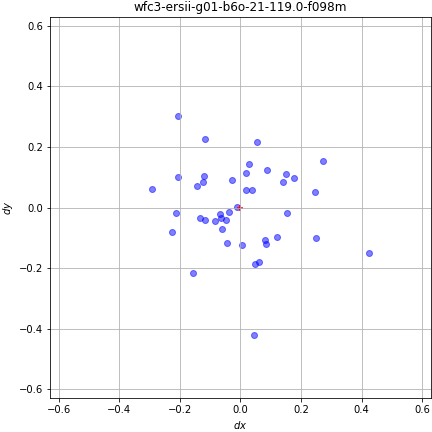

In [21]:
from IPython.display import Image
Image(filename = "./wfc3-ersii-g01-b6o-21-119.0-f098m_wcs.png", width=600, height=600)

In [22]:
!ls *_wcs.*
print('')
!cat *wcs.log

wfc3-ersii-g01-b6o-21-119.0-f098m_wcs.fits
wfc3-ersii-g01-b6o-21-119.0-f098m_wcs.log
wfc3-ersii-g01-b6o-21-119.0-f098m_wcs.png
wfc3-ersii-g01-b6o-23-119.0-f140w_wcs.fits
wfc3-ersii-g01-b6o-23-119.0-f140w_wcs.log
wfc3-ersii-g01-b6o-23-119.0-f140w_wcs.png

# ext xshift yshift rot scale rms N
# radec: ../Catalog/goodss_radec.dat
# wfc3-ersii-g01-b6o-21-119.0-f098m
    0       -3.2417        2.6065       -0.0002       0.99997         0.090   42
# ext xshift yshift rot scale rms N
# radec: ../Catalog/goodss_radec.dat
# wfc3-ersii-g01-b6o-23-119.0-f140w
    0       -3.2235        2.8257        0.0074       0.99993         0.067   94


### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

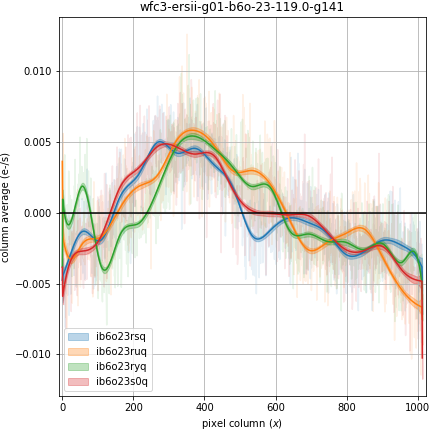

In [23]:
from IPython.display import Image
Image(filename = "./wfc3-ersii-g01-b6o-23-119.0-g141_column.png", width=600, height=600)

## `GroupFLT`: Container object for multple grism FLTs ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

In [24]:
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults

all_grism_files = []
for i in range(len(visits)):
    if '-g1' in visits[i]['product']:
        all_grism_files.extend(visits[i]['files'])
        
grp = GroupFLT(grism_files=all_grism_files, direct_files=[], 
              ref_file='../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits',
              seg_file='../Catalog/ERS_GOODS-S_IR.seg.fits',
              catalog='../Catalog/ERS_GOODS-S_IR.cat',
              cpu_count=8)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pi

Image cutout: x=slice(0, 3600, None), y=slice(0, 3250, None) [Out of range]
ib6o21qmq_flt.fits / blot reference ../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits[0]
Image cutout: x=slice(0, 3600, None), y=slice(0, 3250, None) [Out of range]
ib6o21r6q_flt.fits / blot reference ../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits[0]
Image cutout: x=slice(0, 3600, None), y=slice(0, 3250, None) [Out of range]
ib6o21qoq_flt.fits / blot reference ../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits[0]
Image cutout: x=slice(0, 3600, None), y=slice(0, 3250, None) [Out of range]
ib6o21r8q_flt.fits / blot reference ../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits[0]
Image cutout: x=slice(0, 3600, None), y=slice(0, 3250, None) [Out of range]
ib6o23ruq_flt.fits / blot reference ../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits[0]
Image cutout: x=slice(0, 3600, None), y=slice(0, 3250, None) [Out of range]
ib6o23s0q_flt.fits / blot reference ../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.

Files loaded - 33.71 sec.


### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

In [25]:
# Compute the flat continuum model
grp.compute_full_model(mag_limit=25)

ib6o21qmq_flt.fits: _compute_model Done
ib6o21r8q_flt.fits: _compute_model Done
ib6o21r6q_flt.fits: _compute_model Done
ib6o21qoq_flt.fits: _compute_model Done
ib6o23rsq_flt.fits: _compute_model Done
ib6o23ruq_flt.fits: _compute_model Done
ib6o23s0q_flt.fits: _compute_model Done
ib6o23ryq_flt.fits: _compute_model Done
Models computed - 109.02 sec.


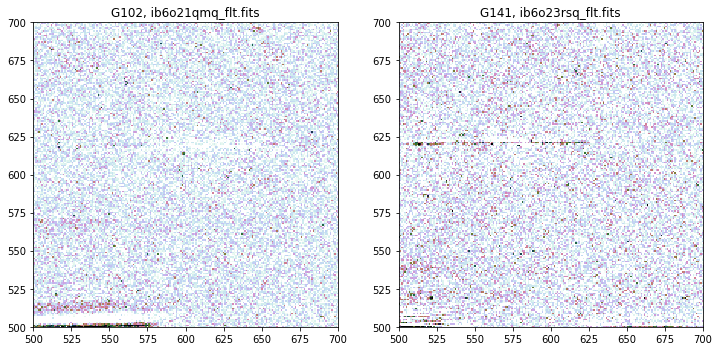

In [31]:
### Show FLT residuals
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(121)
ax.imshow(grp.FLTs[0].grism['SCI'] - grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
          interpolation='Nearest', origin='lower')
ax.set_title('G102, %s' %(grp.FLTs[0].grism.parent_file))

ax = fig.add_subplot(122)
ax.imshow(grp.FLTs[4].grism['SCI'] - grp.FLTs[4].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
          interpolation='Nearest', origin='lower')
ax.set_title('G141, %s' %(grp.FLTs[4].grism.parent_file))

for ax in fig.axes:
    ax.set_xlim(500,700); ax.set_ylim(500,700)

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

In [29]:
### Refine the (polynomial) continuum model for brighter objects
grp.refine_list(poly_order=2, mag_limits=[16, 24], verbose=False)

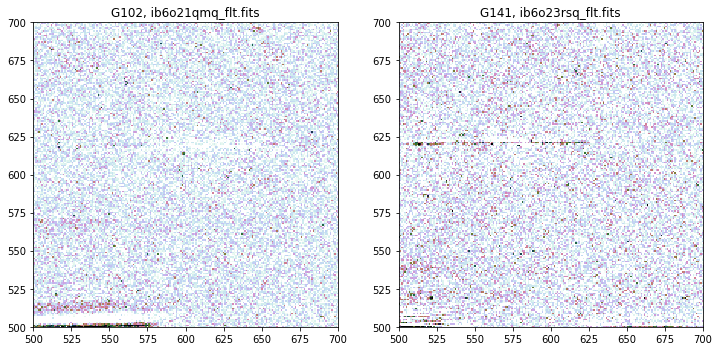

In [30]:
### Show FLT residuals
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(121)
ax.imshow(grp.FLTs[0].grism['SCI'] - grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
          interpolation='Nearest', origin='lower')
ax.set_title('G102, %s' %(grp.FLTs[0].grism.parent_file))

ax = fig.add_subplot(122)
ax.imshow(grp.FLTs[4].grism['SCI'] - grp.FLTs[4].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
          interpolation='Nearest', origin='lower')
ax.set_title('G141, %s' %(grp.FLTs[4].grism.parent_file))

for ax in fig.axes:
    ax.set_xlim(500,700); ax.set_ylim(500,700)

### Save state ###
You can optionally dump saved data for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.

In [32]:
grp.save_full_data()

Save ib6o21qmq.01.GrismFLT.fits


Save ib6o21qoq.01.GrismFLT.fits
Save ib6o21r6q.01.GrismFLT.fits
Save ib6o21r8q.01.GrismFLT.fits
Save ib6o23rsq.01.GrismFLT.fits
Save ib6o23ruq.01.GrismFLT.fits
Save ib6o23ryq.01.GrismFLT.fits
Save ib6o23s0q.01.GrismFLT.fits


In [33]:
# This will now be much faster and contains the full "refined" model
grp = GroupFLT(grism_files=all_grism_files, direct_files=[], 
              ref_file='../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits',
              seg_file='../Catalog/ERS_GOODS-S_IR.seg.fits',
              catalog='../Catalog/ERS_GOODS-S_IR.cat',
              cpu_count=8)

Load ib6o21qmq.01.GrismFLT.fits!
Load ib6o21qoq.01.GrismFLT.fits!
Load ib6o21r6q.01.GrismFLT.fits!
Load ib6o21r8q.01.GrismFLT.fits!
Load ib6o23ruq.01.GrismFLT.fits!
Load ib6o23s0q.01.GrismFLT.fits!
Load ib6o23ryq.01.GrismFLT.fits!
Load ib6o23rsq.01.GrismFLT.fits!
Files loaded - 10.35 sec.


## Fitting individual spectra ##
Now we're done with the preprocessing and can get on with analyzing spectra.

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

Redshift fits are performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:

```bash
# BASH
dist=`python -c "import grizli; print grizli.__file__"`
template_dir=`echo $dist | sed "s/__init__.pyc/data\/templates/"`
echo $template_dir
cd $GRIZLI
ln -s $template_dir ./
```

## ! Note ! ##

While the description above is still generally applicable for the fitting algorithm itself, the steps below are now superseded by the fitting tools in `fitting.py`, which are demonstrated in the [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook.  

In [34]:
## Fit parameters
pzfit, pspec2, pline = get_redshift_fit_defaults()

# Redshift fit
pzfit ['zr'] = [0.5, 2.4]
pzfit['dz'] = [0.005, 0.0005]

# Drizzled line maps
pline = {'kernel': 'square', 'pixfrac': 0.6, 'pixscale': 0.06, 'size': 20}

# Full rectified 2D spectrum
pspec2 = {'NY': 20, 'dlam': 40, 'spatial_scale': 1}

### Object with emission lines ####

The example below shows how to extract the individual "beams" from the `GroupFLT` object and pass them to the `MultiBeam` object, which contains all the tools necessary for fitting the separate spectra together.  The basic redshift fit is wrapped into a single script `run_full_diagnostics`.

**NB** Because we provided the 3D-HST GOODS-S segmentation image and detection catalogs above, the ID numbers below all correspond directly to objects with the same ID in the 3D-HST catalogs and spectral products.

The first object shown below contains clear emission lines in both G141 ([OIII]) and G102 ([OII]) grisms.  The wrapper script produces the following files for each object:

* *ers-grism_zfit_40776.2D.fits*  - Fully combined 2D spectrum with SCI and WHT extensions along with additional extensions the CONTINUUM and FULL model spectra.  The trace has been rectified to lie parallel to image rows.
* *ers-grism_zfit_40776.2D.png*   - The green/yellow figure shown below
* *ers-grism_zfit_40776.beams.dat* - Information on the geometry of the spectrum cutouts
* *ers-grism_zfit_40776.fit.dat*  - Fit information (redshift, line fluxes)
* *ers-grism_zfit_40776.fit.npy*  - Additional data from the fit (template coefficients, best-fit model, etc.)
* *ers-grism_zfit_40776.line.fits* - 2D narrow-band line maps (see below)
* *ers-grism_zfit_40776.png* - The 1D spectrum figure shown below


In [35]:
import grizli.multifit
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults

id=40776
# Extract spectrum cutouts from individual FLTs
beams = grp.get_beams(id, size=80)

# Put them in a `MultiBeam` object
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism')

# Run the redshift fit and generate the emission line map
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)

fit, fig, fig2, hdu2, hdu_line = out

First iteration: z_best=1.7469

 Zoom iteration: z_best=1.7420



TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

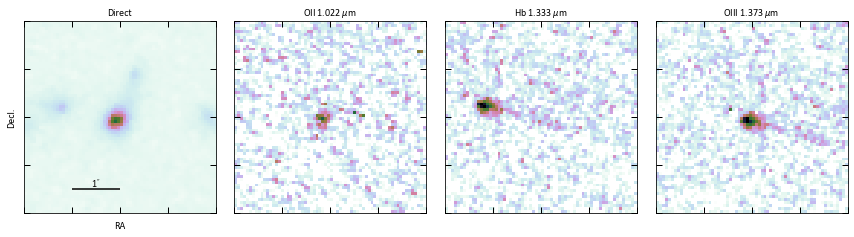

In [19]:
# Emission line maps
im = pyfits.open('ers-grism_40776.line.fits')
fig = plt.figure(figsize=[12,3])

# Direct
ax = fig.add_subplot(141)
ax.imshow(im['DSCI'].data, vmin=-0.02, vmax=0.4, cmap='cubehelix_r', origin='lower')
ax.set_title('Direct')
ax.set_xlabel('RA'); ax.set_ylabel('Decl.')

# 1" ticks
from matplotlib.ticker import MultipleLocator
pix_size = np.abs(im['DSCI'].header['CD1_1']*3600)
majorLocator = MultipleLocator(1./pix_size)
N = pline['size']/pix_size/2
ax.errorbar([N-0.5/pix_size], N-1.5/pix_size, yerr=0, xerr=0.5/pix_size, color='k')
ax.text(N-0.5/pix_size, N-1.5/pix_size, r'$1^{\prime\prime}$', ha='center', va='bottom', color='k')

# Line maps
for i, line in enumerate(['OII', 'Hb', 'OIII']):
    ax = fig.add_subplot(142+i)
    ax.imshow(im['LINE',line].data, vmin=-0.02, vmax=0.3, cmap='cubehelix_r', origin='lower')
    ax.set_title(r'%s %.3f $\mu$m' %(line, im['LINE', line].header['WAVELEN']/1.e4))

# End things
for ax in fig.axes:
    ax.set_yticklabels([]); ax.set_xticklabels([])
    ax.set_xlim(N+np.array([-2,2])/pix_size)
    ax.set_ylim(N+np.array([-2,2])/pix_size)
    
    ax.xaxis.set_major_locator(majorLocator)
    ax.yaxis.set_major_locator(majorLocator)
    
fig.tight_layout(pad=0.5)

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

First iteration: z_best=1.9022

 Zoom iteration: z_best=1.8988

Drizzle line -> OIII (0.66 1.56)
Drizzle line -> Hb   (0.48 1.41)
Drizzle line -> OII  (3.83 1.63)


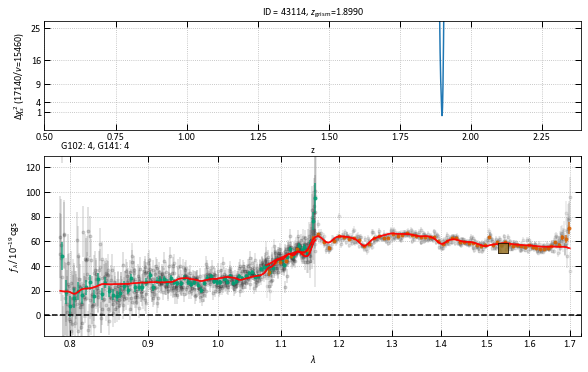

In [20]:
id=43114
beams = grp.get_beams(id, size=80)
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism')
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)

### Weaker continuum features ###

With sufficient S/N, precise redshifts can be determined from the continuum alone even without photometric constraints.  The object below has a ground-based spectroscopic redshift z=0.735.

First iteration: z_best=0.7341

 Zoom iteration: z_best=0.7372

Drizzle line -> Ha   (3.06 1.12)
Drizzle line -> OIII (4.05 3.37)


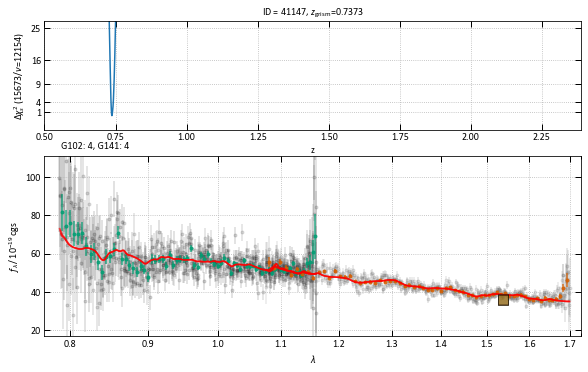

In [21]:
# Continuum, weak features
id=41147 # z_spec = 0.735
beams = grp.get_beams(id, size=80)
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism')
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)

### Stars ### 

Point sources are usually fairly easy to distinguish in HST imaging alone.  The `MultiBeam` object provides a separate method for performing fits with stellar templates (e.g., Pickles, BPGS, SpeX libraries, fixed to z=0).  

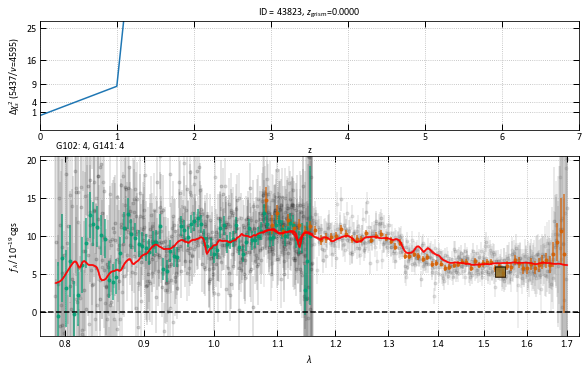

In [22]:
# star
pzfit ['zr'] = 0 # toggle stellar fit
id = 43823
beams = grp.get_beams(id, size=80)
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism', psf=False)
#mb.write_beam_fits()
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)

**EXPERIMENTAL:** Use the WFC3 ["Effective PSF"](http://www.stsci.edu/hst/wfc3/analysis/PSF) as the morphological reference.  This method fits the ePSF model to the direct image at the wavelength of the direct imaging filter and then uses the filter/wavelelength dependent ePSF to interpolate along the trace.  Note that the residuals in the 2D spectrum of the fit below are significantly reduced compared to the previous fit, where the residuals were smallest only near the central wavelength of the direct imaging filter (F140W). 

*NB:* This currently only works with the `BeamCutout` and `MultiBeam` objects.  It's not able to project the ePSF model spectra back to the global contamination model.

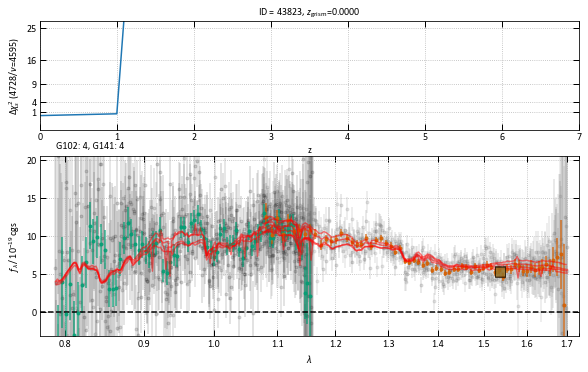

In [23]:
# star
pzfit ['zr'] = 0 # toggle stellar fit
id = 43823
beams = grp.get_beams(id, size=80)
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism', psf=True)
#mb.write_beam_fits()
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)